In [2]:
!pip install shap
!pip install optuna

from __future__ import print_function, division   # Ensures Python3 printing & division standard
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import time
from tqdm import tqdm
import seaborn as sns
sns.set_theme()

# ML
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
import xgboost as xgb
import shap # shap values
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error

# hyperparameter search
import optuna
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV # grid/random search
from bayes_opt import BayesianOptimization # bayesian search
from scipy.stats import uniform, randint # probability distributions
from sklearn.feature_selection import VarianceThreshold # variance analysis

# random seed
np.random.seed(42)

In [3]:
# ===============================
# define function for evaluation
# ===============================

def evaluate_regression(xgb_reg, X_train, y_train, y_test, y_pred, k=5):
    # input: xgb_reg = XGBoost regression
    # input: X_train = data training
    # input: y_train = target training
    # input: y_test = we divided our y (labeled feature we want to know) into train, test, validation, y_test is the part from test
    # input: y_pred = is the y values (here energy) predicted for the X_test
    # checked on 19/05/2024
    
    # Evaluate the model using mean absolute error
    mae = mean_absolute_error(y_test, y_pred)
    print(f"Mean Absolute Error: {mae}")
    
    # Evaluate the model using mean squared error
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    print(f"Mean Squared Error: {mse}")
    print(f"Root Mean Squared Error: {rmse}")
    
    # Evaluate the model using R-squared (R2) score
    r2 = r2_score(y_test, y_pred)
    print(f"R-squared Score: {r2}")
    
    # Evaluate the model using median absolute error
    medae = median_absolute_error(y_test, y_pred)
    print(f"Median Absolute Error: {medae}")

    # Compute the Mean Absolute Error on relative estimate accuracy: (E_pred-E_true)/E_true
    relative_errors = np.abs((y_pred - y_test) / y_test)
    mae_relative = np.mean(relative_errors)
    print(f"Mean Absolute Error on Relative Estimate Accuracy: {mae_relative}")

    # Perform k-fold cross-validation (e.g., k=5)
    cv_scores = cross_val_score(xgb_reg, X_train, y_train, cv=k, scoring='neg_mean_absolute_error')
    print("Cross-Validation: %.4f +- %.4f" %(-cv_scores.mean(), cv_scores.std()))

def test_overfitting(estimator, score_func, X_train, y_train, X_test, y_test, X_valid, y_valid, prob=False):
    # input: score_func = function, like mean_absolute_error for regression
    # input: prob = bool, to use either probability prediction or number/discrete prediction for score function
    # checked 19/05/2024

    if prob:
        y_pred_train = estimator.predict_proba(X_train)
        y_pred_test = estimator.predict_proba(X_test)
        y_pred_valid = estimator.predict_proba(X_valid)
    else:        
        y_pred_train = estimator.predict(X_train)
        y_pred_test = estimator.predict(X_test)
        y_pred_valid = estimator.predict(X_valid)
    
    accuracy_train = score_func(y_train, y_pred_train)
    accuracy_test = score_func(y_test, y_pred_test)
    accuracy_valid = score_func(y_valid, y_pred_valid)
    
    print(f"Training Accuracy: {accuracy_train:.4f}")
    print(f"Test Accuracy: {accuracy_test:.4f}")
    print(f"Valid Accuracy: {accuracy_valid:.4f}")

    # if I want to plot evolution of training and validation metrics I can either use in build function like in tensorflow or create a list
    # of training scores and validation scores depending on n_estimators/epochs --- but this need computational power --- probably

def evaluation_plot(estimator, y_test, y_pred):
    # input: estimator = xgb_cl - XGBClassifier with all the hyperparameter, for example
    # input: y_test = we divided our y (labeled feature we want to know) into train, test, validation, y_test is the part from test 
    # input: y_pred = is the y values predicted for the X_test
    # plot the figures from the feedback document of the inital project in applied machine learning 2024 
    # (Diversion, Distribution Residuals and Relative Errors)
    # checked 04/06/2024

    y_test = np.array(y_test) 
    residuals = y_test - y_pred
    relative_errors = residuals / np.abs(y_test)
    relative_errors = relative_errors[np.abs(relative_errors) <= 1.5]
    percentile_90 = np.percentile(np.abs(residuals), 90)
    high_residual_mask = np.abs(residuals) <= percentile_90

    # Plot the Distribution of the Residuals and the Relative Errors
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,6))
    ax1.hist(residuals, bins=100)
    ax1.set_title('Distribution of Residuals')
    ax1.set_xlabel('Residuals')
    ax1.set_ylabel('Count')
    #ax1.set_xlim()
    
    ax2.hist(relative_errors, bins=100)
    ax2.set_title('Distribution of Relative Errors')
    ax2.set_xlabel('Relative Prediction Error')
    ax2.set_ylabel('Count')
    ax2.set_xlim(-1.5, 1.5)
    plt.tight_layout()
    plt.show()
    
    # Plot the Diversion
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, c='blue', alpha=0.1, label='100th percentile')
    plt.scatter(y_test[high_residual_mask], y_pred[high_residual_mask], c='green', alpha=0.1, label='residual <= 90th percentile')
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='orange', linewidth=2)
    plt.xlabel('Label [m]')
    plt.ylabel('Prediction [m]')
    plt.title('Thickness Diversion')
    plt.legend()
    #plt.savefig('Diversion.png', dpi=300, bbox_inches='tight', format='png')
    plt.show()
    
    # Plot the RMSE for training and validation sets
    results = estimator.evals_result()
    epochs = len(results['validation_0']['mae'])
    x_axis = range(0, epochs)

    # Plot RMSE and MAE metric
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,6))
    ax1.plot(x_axis, results['validation_0']['rmse'], label='Train')
    ax1.plot(x_axis, results['validation_1']['rmse'], label='Test')
    ax1.plot(x_axis, results['validation_2']['rmse'], label='Validation')
    ax1.legend(loc='upper right')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('RMSE')
    ax1.set_title('Evolution of the Root Mean Squared Error')

    ax2.plot(x_axis, results['validation_0']['mae'], label='Train')
    ax2.plot(x_axis, results['validation_1']['mae'], label='Test')
    ax2.plot(x_axis, results['validation_2']['mae'], label='Validation')
    ax2.legend(loc='upper right')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('MAE')
    ax2.set_title('Evolution of the Mean Absolute Error')
    plt.tight_layout()
    plt.show()
    
    

In [5]:
class CFG:
    min_thick_value_train = 1.0

    featuresSmall = ['RGI', 'Area', 'Zmin', 'Zmax', 'Zmed', 'Slope', 'Lmax', 'Form', 'TermType', 'Aspect',
                     'elevation', 'elevation_from_zmin', 'dist_from_border_km_geom',
                     'slope50', 'slope100', 'slope150', 'slope300', 'slope450', 'slopegfa',
                     'curv_50', 'curv_300', 'curv_gfa', 'aspect_50', 'aspect_300', 'aspect_gfa', 'lat', 'dmdtda_hugo',
                     'smb']

    features_train = featuresSmall + ['vx_gfa', 'vy_gfa', 'v50', 'v100', 'v150', 'v300', 'v450', 'vgfa']
    target = 'THICKNESS'
    millan = 'ith_m'
    farinotti = 'ith_f'

    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=5000, 
                             eval_metric=["mae", "rmse"], random_state=42)

Our Datasets:
- n0_wpics_feat_metadata19_hmineq0.0_tmin20050000_mean_grid_20.csv: no zeros, replaced by mean values of the models + removed <= 0 + satellite images features from VGG16
- metadata19.csv: original dataset without pre-processing
- metadata19_hmineq0.0_tmin20050000_mean_grid_20.csv: training data 20x20 grid
- metadata19_hmineq0.0_tmin20050000_mean_grid_50.csv: training data 50x50 grid
- metadata19_hmineq0.0_tmin20050000_mean_grid_100.csv: training data 100x100 grid
- n0_wpics_metadata19_hmineq0.0_tmin20050000_mean_grid_20-1.csv: no zeros, replaced by mean values of the models + removed <= 0 + images as arrays in last column for own trained CNN
- n0_metadata19_hmineq0.0_tmin20050000_mean_grid_100.csv: modified training data 100x100 grid

For only testing the replaced 0, use the last one and drop the column of the images. 

In [6]:
# load the dataset
path = r'data/'
metadata_file = "n0_metadata19_hmineq0.0_tmin20050000_mean_grid_100.csv"
glathida_rgis = pd.read_csv(path + metadata_file, low_memory=False)

In [7]:
# check for nan values and for shape if it uploaded correctly on erda
columns_with_nan = glathida_rgis.columns[glathida_rgis.isna().any()].tolist()
print("Columns with NaN values in data_deep_thick:", columns_with_nan)
print("The shape is ", glathida_rgis.shape)

Columns with NaN values in data_deep_thick: ['ith_m', 'ith_f']
The shape is  (317015, 59)


In [8]:
# pre-processing
#glathida_rgis = glathida_rgis.dropna()
#glathida_rgis = glathida_rgis.loc[glathida_rgis['THICKNESS']>=CFG.min_thick_value_train]

# add some features for training
glathida_rgis['lat'] = glathida_rgis['POINT_LAT']
glathida_rgis['v50'] = np.sqrt(glathida_rgis['vx_gf50']**2 + glathida_rgis['vy_gf50']**2)
glathida_rgis['v100'] = np.sqrt(glathida_rgis['vx_gf100']**2 + glathida_rgis['vy_gf100']**2)
glathida_rgis['v150'] = np.sqrt(glathida_rgis['vx_gf150']**2 + glathida_rgis['vy_gf150']**2)
glathida_rgis['v300'] = np.sqrt(glathida_rgis['vx_gf300']**2 + glathida_rgis['vy_gf300']**2)
glathida_rgis['v450'] = np.sqrt(glathida_rgis['vx_gf450']**2 + glathida_rgis['vy_gf450']**2)
glathida_rgis['vgfa'] = np.sqrt(glathida_rgis['vx_gfa']**2 + glathida_rgis['vy_gfa']**2)
glathida_rgis['dvx'] = np.sqrt(glathida_rgis['dvx_dx']**2 + glathida_rgis['dvx_dy']**2)

glathida_rgis['slope50'] = np.sqrt(glathida_rgis['slope_lon_gf50']**2 + glathida_rgis['slope_lat_gf50']**2)
glathida_rgis['slope100'] = np.sqrt(glathida_rgis['slope_lon_gf100']**2 + glathida_rgis['slope_lat_gf100']**2)
glathida_rgis['slope150'] = np.sqrt(glathida_rgis['slope_lon_gf150']**2 + glathida_rgis['slope_lat_gf150']**2)
glathida_rgis['slope300'] = np.sqrt(glathida_rgis['slope_lon_gf300']**2 + glathida_rgis['slope_lat_gf300']**2)
glathida_rgis['slope450'] = np.sqrt(glathida_rgis['slope_lon_gf450']**2 + glathida_rgis['slope_lat_gf450']**2)
glathida_rgis['slopegfa'] = np.sqrt(glathida_rgis['slope_lon_gfa']**2 + glathida_rgis['slope_lat_gfa']**2)
glathida_rgis['elevation_from_zmin'] = glathida_rgis['elevation'] - glathida_rgis['Zmin']

X = glathida_rgis[CFG.features_train]
y = glathida_rgis[CFG.target]

In [9]:
# split the training set
X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.7, random_state=42) 
X_valid, X_test, y_valid, y_test = train_test_split(X_rem, y_rem, test_size=0.5, random_state=42) 

In [10]:
best_params = {
    'max_depth': 10,
    'learning_rate': 0.071,
    'min_child_weight': 8,
    'subsample': 0.808,
    'gamma': 2.303,
    'alpha': 0.698,
    'lambda': 5.009
}
best_params

{'max_depth': 10,
 'learning_rate': 0.071,
 'min_child_weight': 8,
 'subsample': 0.808,
 'gamma': 2.303,
 'alpha': 0.698,
 'lambda': 5.009}

In [11]:
# train the final model with the best hyperparameters
start_time = time.time()
best_model = xgb.XGBRegressor(**best_params, objective='reg:squarederror', n_estimators=5000, 
                             eval_metric=["mae", "rmse"], random_state=42)
best_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test), (X_valid, y_valid)], early_stopping_rounds=5)
end_time = time.time()
training_time_best = end_time - start_time

y_pred_best = best_model.predict(X_test)

/home/jovyan/work/__dag_config__/python3/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:133.65204	validation_0-rmse:181.48196	validation_1-mae:134.37210	validation_1-rmse:183.84372	validation_2-mae:133.02452	validation_2-rmse:179.45557
[1]	validation_0-mae:125.25535	validation_0-rmse:170.70391	validation_1-mae:125.96625	validation_1-rmse:173.01291	validation_2-mae:124.70957	validation_2-rmse:168.88249
[2]	validation_0-mae:117.47158	validation_0-rmse:160.71372	validation_1-mae:118.18210	validation_1-rmse:162.97414	validation_2-mae:117.01373	validation_2-rmse:159.07255
[3]	validation_0-mae:110.23823	validation_0-rmse:151.42584	validation_1-mae:110.95979	validation_1-rmse:153.64518	validation_2-mae:109.85669	validation_2-rmse:149.99972
[4]	validation_0-mae:103.55741	validation_0-rmse:142.81743	validation_1-mae:104.29603	validation_1-rmse:145.02920	validation_2-mae:103.25209	validation_2-rmse:141.59555
[5]	validation_0-mae:97.36872	validation_0-rmse:134.85454	validation_1-mae:98.11366	validation_1-rmse:137.02120	validation_2-mae:97.14259	validation_2-rmse

In [12]:
# evaluate the regression
print(f"Training time: {training_time_best:.2f} seconds")
evaluate_regression(best_model, X_train, y_train, y_test, y_pred_best, k=5)
test_overfitting(best_model, mean_absolute_error, X_train, y_train, X_test, y_test, X_valid, y_valid)

Training time: 534.74 seconds
Mean Absolute Error: 12.41951546541047
Mean Squared Error: 690.7105041409018
Root Mean Squared Error: 26.281371808581486
R-squared Score: 0.9819434614847157
Median Absolute Error: 5.129638671875
Mean Absolute Error on Relative Estimate Accuracy: 0.45475221326635856
Cross-Validation: 13.6754 +- 0.1162
Training Accuracy: 1.4478
Test Accuracy: 12.4195
Valid Accuracy: 12.5476


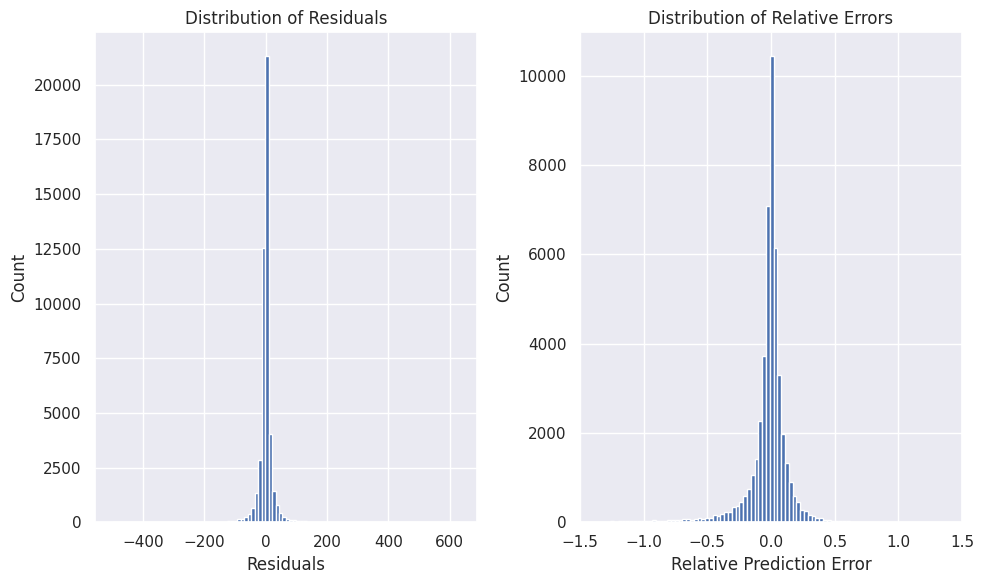

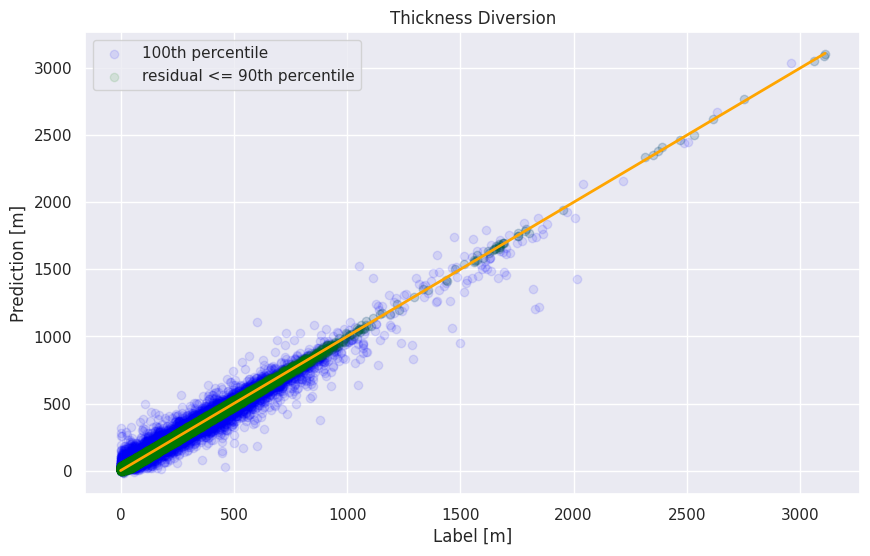

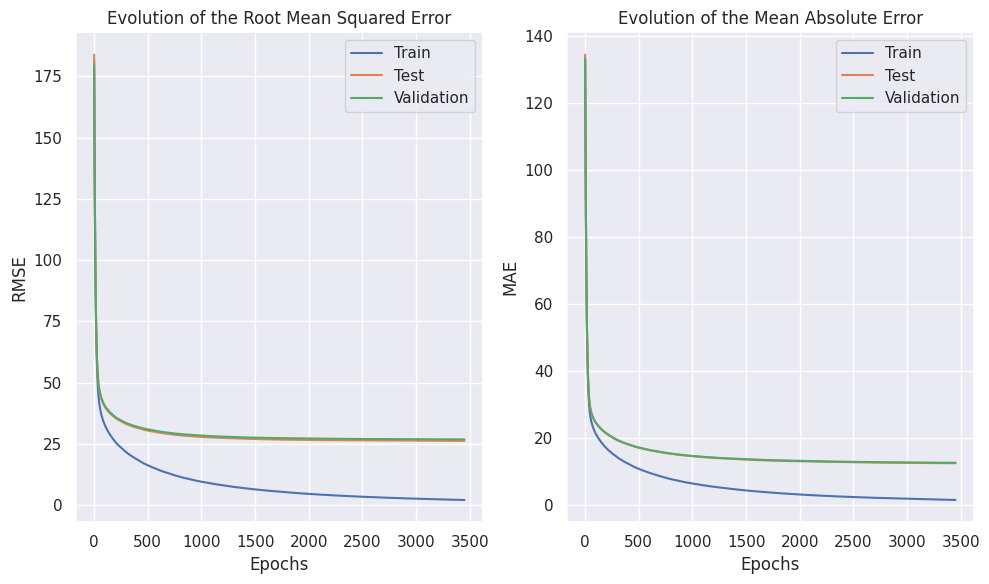

In [13]:
# plot evaluation
evaluation_plot(best_model, y_test, y_pred_best)

### Using the Best Model on the Regional Data

In [ ]:
metadata_file = "metadata19.csv" 
data_regional = pd.read_csv(path + metadata_file, low_memory=False)
data_regional = data_regional.loc[data_regional['THICKNESS']>=CFG.min_thick_value_train]

In [ ]:
data_regional['lat'] = data_regional['POINT_LAT']
data_regional['v50'] = np.sqrt(data_regional['vx_gf50']**2 + data_regional['vy_gf50']**2)
data_regional['v100'] = np.sqrt(data_regional['vx_gf100']**2 + data_regional['vy_gf100']**2)
data_regional['v150'] = np.sqrt(data_regional['vx_gf150']**2 + data_regional['vy_gf150']**2)
data_regional['v300'] = np.sqrt(data_regional['vx_gf300']**2 + data_regional['vy_gf300']**2)
data_regional['v450'] = np.sqrt(data_regional['vx_gf450']**2 + data_regional['vy_gf450']**2)
data_regional['vgfa'] = np.sqrt(data_regional['vx_gfa']**2 + data_regional['vy_gfa']**2)
data_regional['dvx'] = np.sqrt(data_regional['dvx_dx']**2 + data_regional['dvx_dy']**2)

data_regional['slope50'] = np.sqrt(data_regional['slope_lon_gf50']**2 + data_regional['slope_lat_gf50']**2)
data_regional['slope100'] = np.sqrt(data_regional['slope_lon_gf100']**2 + data_regional['slope_lat_gf100']**2)
data_regional['slope150'] = np.sqrt(data_regional['slope_lon_gf150']**2 + data_regional['slope_lat_gf150']**2)
data_regional['slope300'] = np.sqrt(data_regional['slope_lon_gf300']**2 + data_regional['slope_lat_gf300']**2)
data_regional['slope450'] = np.sqrt(data_regional['slope_lon_gf450']**2 + data_regional['slope_lat_gf450']**2)
data_regional['slopegfa'] = np.sqrt(data_regional['slope_lon_gfa']**2 + data_regional['slope_lat_gfa']**2)
data_regional['elevation_from_zmin'] = data_regional['elevation'] - data_regional['Zmin']


data_regional_mod = data_regional[CFG.features_train]
#Invalid columns:POLITICAL_UNIT: object, GLACIER_NAME: object, PROFILE_ID: object, POINT_ID: object, REMARKS: object

In [ ]:
y_pred_regional = model.predict(data_regional_mod)

In [ ]:
evaluation_plot(model, data_regional['THICKNESS'], y_pred_regional)

### Predicting the Metadata19.csv - the regional Data

In [18]:
data_regional.columns

Index(['GlaThiDa_ID', 'POLITICAL_UNIT', 'GLACIER_NAME', 'SURVEY_DATE',
       'PROFILE_ID', 'POINT_ID', 'POINT_LAT', 'POINT_LON', 'ELEVATION',
       'THICKNESS', 'THICKNESS_UNCERTAINTY', 'DATA_FLAG', 'REMARKS', 'RGI',
       'RGIId', 'Area', 'Zmin', 'Zmax', 'Zmed', 'Slope', 'Lmax', 'Form',
       'TermType', 'Aspect', 'dmdtda_hugo', 'elevation', 'slope_lat',
       'slope_lon', 'slope_lat_gf50', 'slope_lon_gf50', 'slope_lat_gf100',
       'slope_lon_gf100', 'slope_lat_gf150', 'slope_lon_gf150',
       'slope_lat_gf300', 'slope_lon_gf300', 'slope_lat_gf450',
       'slope_lon_gf450', 'slope_lat_gfa', 'slope_lon_gfa', 'curv_50',
       'curv_300', 'curv_gfa', 'aspect_50', 'aspect_300', 'aspect_gfa', 'smb',
       'ith_m', 'vx', 'vy', 'vx_gf50', 'vx_gf100', 'vx_gf150', 'vx_gf300',
       'vx_gf450', 'vx_gfa', 'vy_gf50', 'vy_gf100', 'vy_gf150', 'vy_gf300',
       'vy_gf450', 'vy_gfa', 'dvx_dx', 'dvx_dy', 'dvy_dx', 'dvy_dy',
       'dist_from_border_km_geom', 'ith_f'],
      dtype='object'

In [26]:
# =============================================
# Train on larger Thickness from metadata19.csv
# =============================================

data_deep_thick = data_regional[data_regional['THICKNESS'] >= 1000]
data_regional.shape, data_deep_thick.shape

((3679351, 68), (34879, 68))

In [29]:
data_regional['lat'] = data_regional['POINT_LAT']
data_regional['v50'] = np.sqrt(data_regional['vx_gf50']**2 + data_regional['vy_gf50']**2)
data_regional['v100'] = np.sqrt(data_regional['vx_gf100']**2 + data_regional['vy_gf100']**2)
data_regional['v150'] = np.sqrt(data_regional['vx_gf150']**2 + data_regional['vy_gf150']**2)
data_regional['v300'] = np.sqrt(data_regional['vx_gf300']**2 + data_regional['vy_gf300']**2)
data_regional['v450'] = np.sqrt(data_regional['vx_gf450']**2 + data_regional['vy_gf450']**2)
data_regional['vgfa'] = np.sqrt(data_regional['vx_gfa']**2 + data_regional['vy_gfa']**2)
data_regional['dvx'] = np.sqrt(data_regional['dvx_dx']**2 + data_regional['dvx_dy']**2)

data_regional['slope50'] = np.sqrt(data_regional['slope_lon_gf50']**2 + data_regional['slope_lat_gf50']**2)
data_regional['slope100'] = np.sqrt(data_regional['slope_lon_gf100']**2 + data_regional['slope_lat_gf100']**2)
data_regional['slope150'] = np.sqrt(data_regional['slope_lon_gf150']**2 + data_regional['slope_lat_gf150']**2)
data_regional['slope300'] = np.sqrt(data_regional['slope_lon_gf300']**2 + data_regional['slope_lat_gf300']**2)
data_regional['slope450'] = np.sqrt(data_regional['slope_lon_gf450']**2 + data_regional['slope_lat_gf450']**2)
data_regional['slopegfa'] = np.sqrt(data_regional['slope_lon_gfa']**2 + data_regional['slope_lat_gfa']**2)
data_regional['elevation_from_zmin'] = data_regional['elevation'] - data_regional['Zmin']


data_regional_mod = data_regional[CFG.features_train]
#Invalid columns:POLITICAL_UNIT: object, GLACIER_NAME: object, PROFILE_ID: object, POINT_ID: object, REMARKS: object

In [37]:
# Assign new columns using .loc
data_deep_thick.loc[:, 'lat'] = data_deep_thick['POINT_LAT']
data_deep_thick.loc[:, 'v50'] = np.sqrt(data_deep_thick['vx_gf50']**2 + data_deep_thick['vy_gf50']**2)
data_deep_thick.loc[:, 'v100'] = np.sqrt(data_deep_thick['vx_gf100']**2 + data_deep_thick['vy_gf100']**2)
data_deep_thick.loc[:, 'v150'] = np.sqrt(data_deep_thick['vx_gf150']**2 + data_deep_thick['vy_gf150']**2)
data_deep_thick.loc[:, 'v300'] = np.sqrt(data_deep_thick['vx_gf300']**2 + data_deep_thick['vy_gf300']**2)
data_deep_thick.loc[:, 'v450'] = np.sqrt(data_deep_thick['vx_gf450']**2 + data_deep_thick['vy_gf450']**2)
data_deep_thick.loc[:, 'vgfa'] = np.sqrt(data_deep_thick['vx_gfa']**2 + data_deep_thick['vy_gfa']**2)
data_deep_thick.loc[:, 'dvx'] = np.sqrt(data_deep_thick['dvx_dx']**2 + data_deep_thick['dvx_dy']**2)

data_deep_thick.loc[:, 'slope50'] = np.sqrt(data_deep_thick['slope_lon_gf50']**2 + data_deep_thick['slope_lat_gf50']**2)
data_deep_thick.loc[:, 'slope100'] = np.sqrt(data_deep_thick['slope_lon_gf100']**2 + data_deep_thick['slope_lat_gf100']**2)
data_deep_thick.loc[:, 'slope150'] = np.sqrt(data_deep_thick['slope_lon_gf150']**2 + data_deep_thick['slope_lat_gf150']**2)
data_deep_thick.loc[:, 'slope300'] = np.sqrt(data_deep_thick['slope_lon_gf300']**2 + data_deep_thick['slope_lat_gf300']**2)
data_deep_thick.loc[:, 'slope450'] = np.sqrt(data_deep_thick['slope_lon_gf450']**2 + data_deep_thick['slope_lat_gf450']**2)
data_deep_thick.loc[:, 'slopegfa'] = np.sqrt(data_deep_thick['slope_lon_gfa']**2 + data_deep_thick['slope_lat_gfa']**2)
data_deep_thick.loc[:, 'elevation_from_zmin'] = data_deep_thick['elevation'] - data_deep_thick['Zmin']

In [38]:
# ====================
# Identify NaN values
# ====================

# Step 1: Identify columns with NaN values
columns_with_nan = data_deep_thick.columns[data_deep_thick.isna().any()].tolist()

# Step 2: Print the names of these columns
print("Columns with NaN values in data_deep_thick:", columns_with_nan)

Columns with NaN values in data_deep_thick: ['GLACIER_NAME', 'PROFILE_ID', 'THICKNESS_UNCERTAINTY', 'DATA_FLAG', 'REMARKS', 'ith_m', 'ith_f']


In [39]:
# ===========================
# Train on deeper Thickness
# ===========================

X = data_deep_thick[CFG.features_train]
y = data_deep_thick[CFG.target]

# split the training set
X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.7, random_state=42) 
X_valid, X_test, y_valid, y_test = train_test_split(X_rem, y_rem, test_size=0.5, random_state=42) 

In [40]:
# regression machine learning
eval_set = [(X_train, y_train), (X_test, y_test), (X_valid, y_valid)]

start_time = time.time()
model = CFG.model
model.fit(X_train, y_train, early_stopping_rounds=5, eval_set=eval_set)
end_time = time.time()

training_time = end_time - start_time
print(f"Training time: {training_time:.2f} seconds")

y_pred = model.predict(X_test)

[0]	validation_0-mae:192.83520	validation_0-rmse:235.12723	validation_1-mae:193.40043	validation_1-rmse:236.17164	validation_2-mae:193.66387	validation_2-rmse:235.87234
[1]	validation_0-mae:151.07231	validation_0-rmse:184.53531	validation_1-mae:151.52096	validation_1-rmse:186.05252	validation_2-mae:151.63129	validation_2-rmse:185.54997
[2]	validation_0-mae:122.08907	validation_0-rmse:151.32038	validation_1-mae:122.88167	validation_1-rmse:153.51175	validation_2-mae:123.11503	validation_2-rmse:153.46451
[3]	validation_0-mae:99.94988	validation_0-rmse:127.14319	validation_1-mae:101.40848	validation_1-rmse:130.30791	validation_2-mae:101.17889	validation_2-rmse:130.13717
[4]	validation_0-mae:86.73935	validation_0-rmse:112.58164	validation_1-mae:88.16326	validation_1-rmse:116.07279	validation_2-mae:88.20900	validation_2-rmse:116.25402
[5]	validation_0-mae:75.14983	validation_0-rmse:100.05576	validation_1-mae:76.54418	validation_1-rmse:103.71466	validation_2-mae:76.66488	validation_2-rmse:104

/home/jovyan/work/__dag_config__/python3/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[16]	validation_0-mae:42.33750	validation_0-rmse:62.17525	validation_1-mae:44.51681	validation_1-rmse:67.02203	validation_2-mae:44.91360	validation_2-rmse:70.30765
[17]	validation_0-mae:40.43818	validation_0-rmse:60.01696	validation_1-mae:42.68389	validation_1-rmse:64.99956	validation_2-mae:42.92016	validation_2-rmse:68.19710
[18]	validation_0-mae:39.33188	validation_0-rmse:58.45098	validation_1-mae:41.59917	validation_1-rmse:63.51111	validation_2-mae:41.89234	validation_2-rmse:66.92443
[19]	validation_0-mae:38.60183	validation_0-rmse:57.53722	validation_1-mae:40.84858	validation_1-rmse:62.43441	validation_2-mae:41.18244	validation_2-rmse:66.18661
[20]	validation_0-mae:36.54710	validation_0-rmse:54.87878	validation_1-mae:38.77865	validation_1-rmse:60.08723	validation_2-mae:39.20149	validation_2-rmse:64.07233
[21]	validation_0-mae:36.14791	validation_0-rmse:54.47581	validation_1-mae:38.47281	validation_1-rmse:59.77526	validation_2-mae:38.82751	validation_2-rmse:63.73079
[22]	validation_

In [41]:
# evaluate the regression
print(f"Training time: {training_time:.2f} seconds")
evaluate_regression(model, X_train, y_train, y_test, y_pred, k=5)
test_overfitting(model, mean_absolute_error, X_train, y_train, X_test, y_test, X_valid, y_valid)

Training time: 1.74 seconds
Mean Absolute Error: 21.38836764414376
Mean Squared Error: 1995.7023439133227
Root Mean Squared Error: 44.6732844540596
R-squared Score: 0.9782142639160156
Median Absolute Error: 12.15228271484375
Mean Absolute Error on Relative Estimate Accuracy: 0.016002173692342102
Cross-Validation: 14.2348 +- 0.5344
Training Accuracy: 16.4816
Test Accuracy: 21.3884
Valid Accuracy: 21.0399


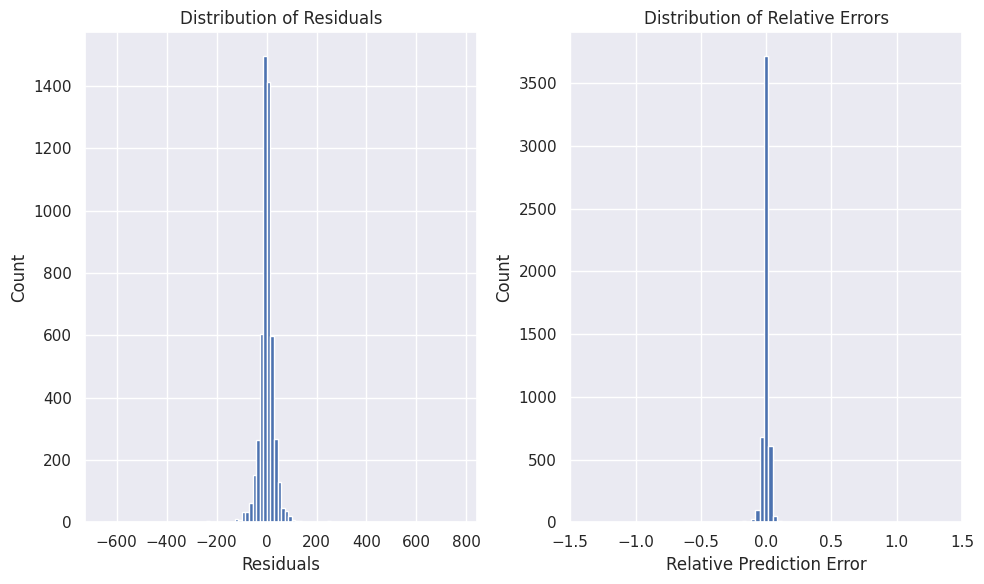

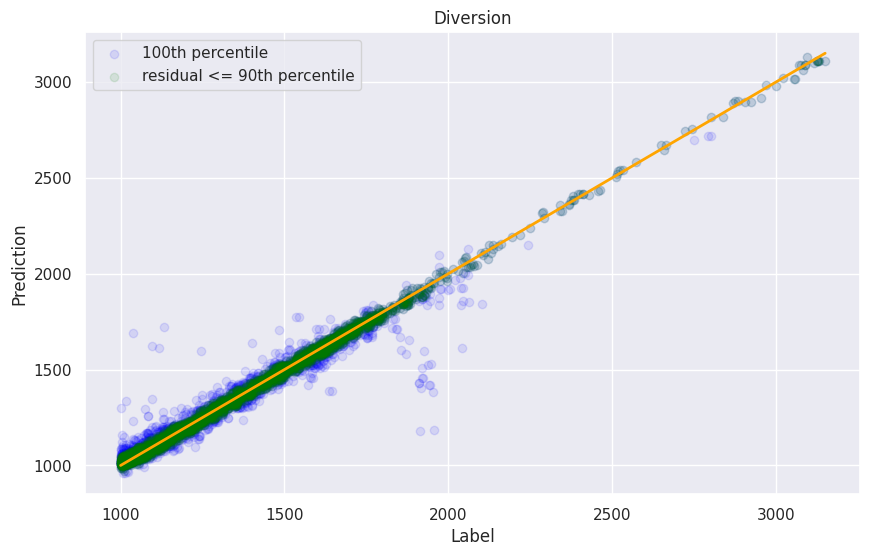

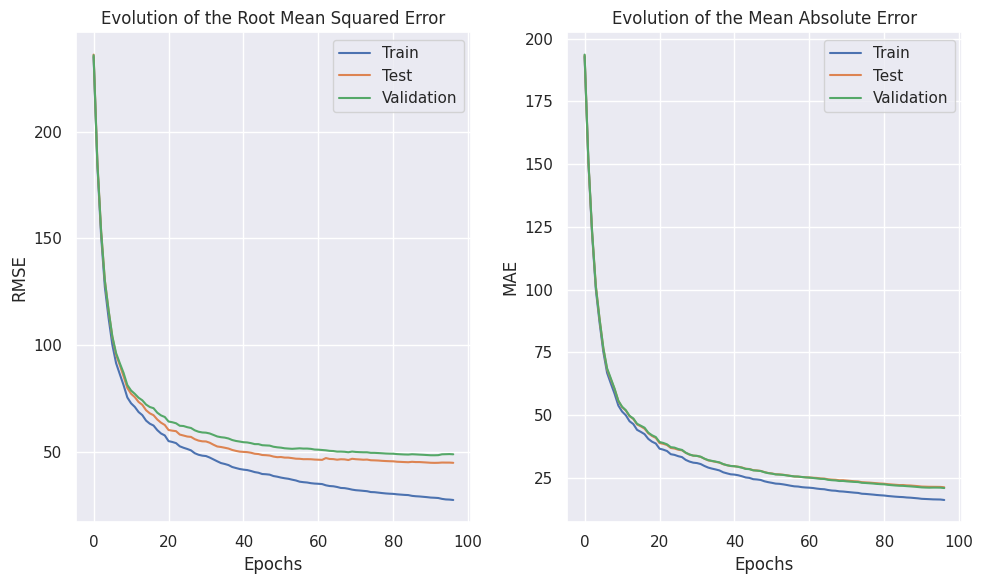

In [62]:
# plot evaluation
evaluation_plot(model, y_test, y_pred)

In [43]:
# Define the objective function for Optuna
def objective(trial):
    params = {
        'objective': 'reg:squarederror',
        'n_estimators': 2000,
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'alpha': trial.suggest_float('alpha', 0, 1),
        'lambda': trial.suggest_float('lambda', 1, 10),
        'random_state': 42
    }
    
    model = xgb.XGBRegressor(**params, eval_metric=["mae", "rmse"], early_stopping_rounds=5)
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
    
    y_pred = model.predict(X_valid)
    mae = mean_absolute_error(y_valid, y_pred)
    return mae

# Create Optuna study and optimize
start_time = time.time()
study = optuna.create_study(direction='minimize')
n_trials = 50
study.optimize(objective, n_trials=n_trials)
end_time = time.time()
training_time_optuna = end_time - start_time


# Print the best hyperparameters
print(f"Best hyperparameters: {study.best_params}")

[I 2024-06-09 12:36:55,518] A new study created in memory with name: no-name-b8a53411-1795-410b-839b-4c62469653c8
[I 2024-06-09 12:37:07,717] Trial 0 finished with value: 30.522093058361556 and parameters: {'max_depth': 6, 'learning_rate': 0.012353850649308759, 'min_child_weight': 1, 'subsample': 0.6539264126091269, 'gamma': 2.950633034236456, 'alpha': 0.2798602772721863, 'lambda': 5.499804775691575}. Best is trial 0 with value: 30.522093058361556.
[I 2024-06-09 12:37:08,079] Trial 1 finished with value: 20.24903614149181 and parameters: {'max_depth': 10, 'learning_rate': 0.25933780748746477, 'min_child_weight': 9, 'subsample': 0.7213502051606105, 'gamma': 3.480170680777853, 'alpha': 0.15687793048031573, 'lambda': 2.5953987342074814}. Best is trial 1 with value: 20.24903614149181.
[I 2024-06-09 12:37:12,928] Trial 2 finished with value: 25.134953723405843 and parameters: {'max_depth': 8, 'learning_rate': 0.022844311654058275, 'min_child_weight': 1, 'subsample': 0.6000733673865926, 'gam

Best hyperparameters: {'max_depth': 10, 'learning_rate': 0.04500029939795595, 'min_child_weight': 8, 'subsample': 0.8290546328045263, 'gamma': 3.9135620473285044, 'alpha': 0.003605028235810104, 'lambda': 2.8623909930278124}


In [44]:
# print training time of optuna hyperparameter optimization
print(f"Optuna Optimization time: {training_time_optuna:.2f} seconds")

Optuna Optimization time: 159.67 seconds


In [54]:
# train the final model with the best hyperparameters
best_params = study.best_params
start_time = time.time()
best_model = xgb.XGBRegressor(**best_params, objective='reg:squarederror', n_estimators=5000, 
                             eval_metric=["mae", "rmse"], random_state=42)
best_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test), (X_valid, y_valid)], early_stopping_rounds=5)
end_time = time.time()
training_time_best = end_time - start_time

y_pred_best = best_model.predict(X_test)

[0]	validation_0-mae:235.49432	validation_0-rmse:289.56530	validation_1-mae:235.80573	validation_1-rmse:290.62372	validation_2-mae:235.69266	validation_2-rmse:289.30341
[1]	validation_0-mae:225.94903	validation_0-rmse:277.95404	validation_1-mae:226.35218	validation_1-rmse:279.11946	validation_2-mae:226.22636	validation_2-rmse:277.82740
[2]	validation_0-mae:217.05751	validation_0-rmse:266.95046	validation_1-mae:217.55315	validation_1-rmse:268.19553	validation_2-mae:217.38073	validation_2-rmse:266.91586
[3]	validation_0-mae:208.33479	validation_0-rmse:256.34418	validation_1-mae:208.89181	validation_1-rmse:257.64117	validation_2-mae:208.78932	validation_2-rmse:256.49075
[4]	validation_0-mae:200.10621	validation_0-rmse:246.19333	validation_1-mae:200.76765	validation_1-rmse:247.63403	validation_2-mae:200.61414	validation_2-rmse:246.47231
[5]	validation_0-mae:192.12891	validation_0-rmse:236.55339	validation_1-mae:192.89293	validation_1-rmse:238.09579	validation_2-mae:192.75683	validation_2-r

/home/jovyan/work/__dag_config__/python3/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[11]	validation_0-mae:151.66000	validation_0-rmse:187.26662	validation_1-mae:152.71531	validation_1-rmse:189.26908	validation_2-mae:152.75720	validation_2-rmse:188.57355
[12]	validation_0-mae:145.93448	validation_0-rmse:180.37600	validation_1-mae:147.04833	validation_1-rmse:182.49238	validation_2-mae:147.10723	validation_2-rmse:181.83671
[13]	validation_0-mae:140.14310	validation_0-rmse:173.38118	validation_1-mae:141.32229	validation_1-rmse:175.60897	validation_2-mae:141.35095	validation_2-rmse:174.93456
[14]	validation_0-mae:135.05991	validation_0-rmse:167.18164	validation_1-mae:136.28960	validation_1-rmse:169.50977	validation_2-mae:136.34336	validation_2-rmse:168.90038
[15]	validation_0-mae:129.75109	validation_0-rmse:160.78458	validation_1-mae:131.03743	validation_1-rmse:163.19132	validation_2-mae:131.03433	validation_2-rmse:162.58298
[16]	validation_0-mae:125.04765	validation_0-rmse:155.10844	validation_1-mae:126.41523	validation_1-rmse:157.64470	validation_2-mae:126.39692	validati

In [55]:
# evaluate the regression
print(f"Training time: {training_time_best:.2f} seconds")
evaluate_regression(best_model, X_train, y_train, y_test, y_pred_best, k=5)
test_overfitting(best_model, mean_absolute_error, X_train, y_train, X_test, y_test, X_valid, y_valid)

Training time: 4.37 seconds
Mean Absolute Error: 18.721731670041333
Mean Squared Error: 1712.0389363555428
Root Mean Squared Error: 41.37679224342485
R-squared Score: 0.9813108444213867
Median Absolute Error: 10.10479736328125
Mean Absolute Error on Relative Estimate Accuracy: 0.01397516390111142
Cross-Validation: 11.9378 +- 0.3351
Training Accuracy: 14.4060
Test Accuracy: 18.7217
Valid Accuracy: 18.4368


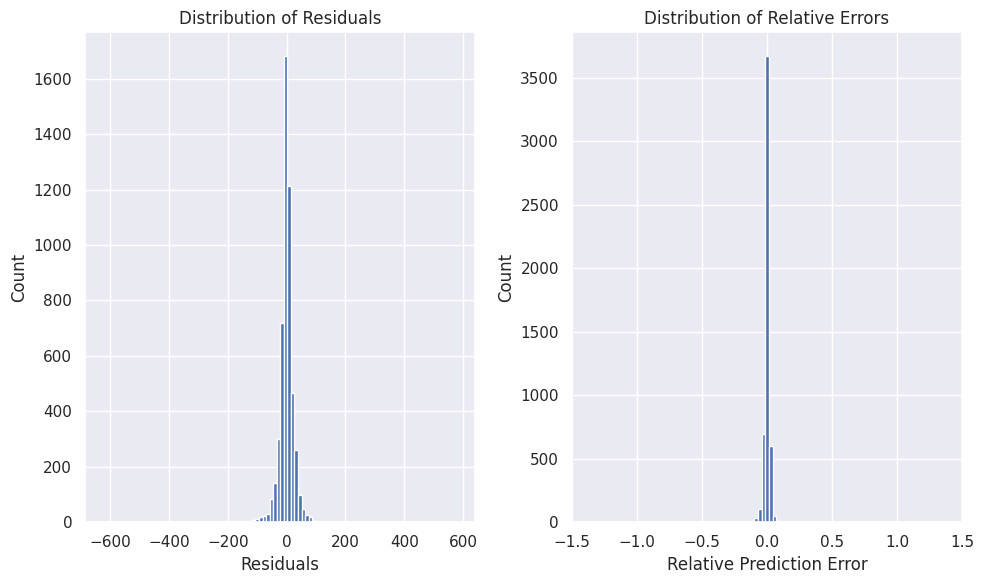

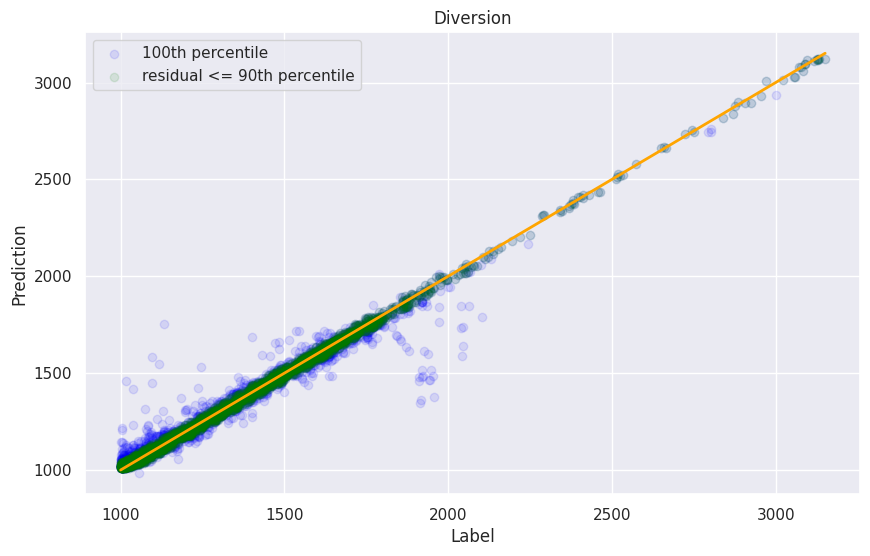

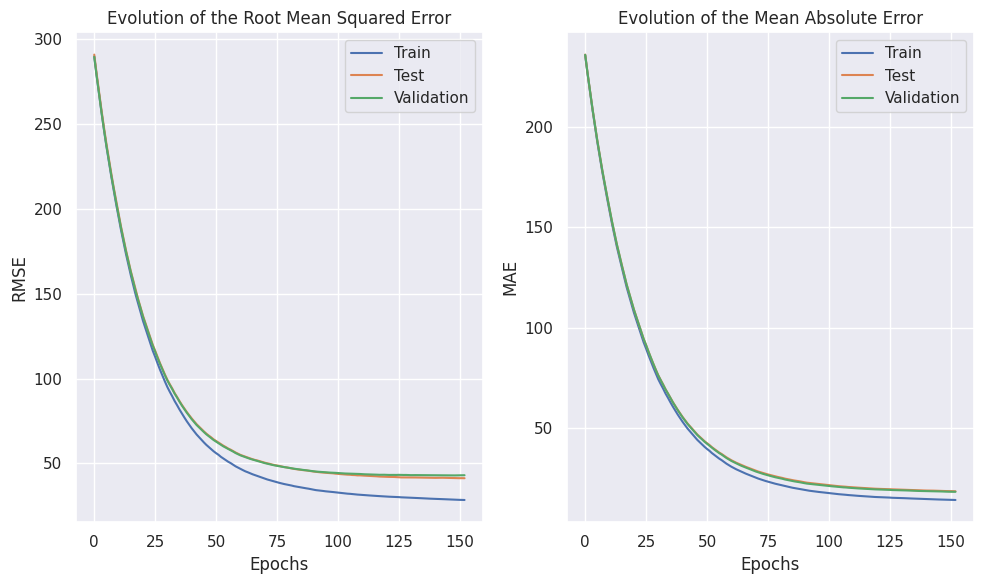

In [61]:
# plot evaluation
evaluation_plot(best_model, y_test, y_pred_best)

In [64]:
data_deep_thick_mod.shape

(34879, 36)

In [ ]:
y_pred_regional = best_model.predict(data_regional_mod)

In [ ]:
evaluation_plot(best_model, data_regional['THICKNESS'], y_pred_regional)